### Tile Coding Implementation

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
class TileCoder:
    """
    Tile coding for continuous state spaces.

    Creates multiple overlapping tilings (grids) over the state space.
    Each tiling is offset slightly, providing fine resolution where
    tilings overlap differently.
    """

    def __init__(self, num_tilings: int, tiles_per_dim: List[int],
                 state_bounds: List[Tuple[float, float]]):
        """
        Initialize tile coder.

        Args:
            num_tilings: Number of overlapping tilings (typically 8-16)
            tiles_per_dim: Number of tiles per dimension [n1, n2, ...]
            state_bounds: [(low, high), ...] bounds for each dimension
        """
        self.num_tilings = num_tilings
        self.tiles_per_dim = np.array(tiles_per_dim)
        self.state_bounds = state_bounds
        self.num_dims = len(tiles_per_dim)

        # Calculate tile widths for each dimension
        self.tile_widths = np.array([
            (high - low) / n_tiles
            for (low, high), n_tiles in zip(state_bounds, tiles_per_dim)
        ])

        # Create asymmetric offsets for each tiling
        # Asymmetric offsets prevent tilings from aligning
        self.offsets = []
        for i in range(num_tilings):
            # Each tiling offset by different fraction of tile width
            offset = np.array([
                (i * self.tile_widths[d]) / num_tilings
                for d in range(self.num_dims)
            ])
            self.offsets.append(offset)

        # Total number of features (tiles across all tilings)
        self.tiles_per_tiling = int(np.prod(tiles_per_dim))
        self.num_features = num_tilings * self.tiles_per_tiling

    def get_active_tiles(self, state: np.ndarray) -> List[int]:
        """
        Get indices of active tiles for a given state.

        Returns exactly num_tilings active tiles (one per tiling).

        Args:
            state: Continuous state vector

        Returns:
            List of active tile indices
        """
        active_tiles = []

        for tiling_idx, offset in enumerate(self.offsets):
            # Compute tile coordinates in this tiling
            coords = []
            for dim in range(self.num_dims):
                low, high = self.state_bounds[dim]

                # Shift state by offset and compute tile index
                shifted = state[dim] - low - offset[dim]
                tile_coord = int(np.floor(shifted / self.tile_widths[dim]))

                # Clip to valid range
                tile_coord = np.clip(tile_coord, 0, self.tiles_per_dim[dim] - 1)
                coords.append(tile_coord)

            # Convert multi-dimensional coords to flat index
            flat_idx = 0
            multiplier = 1
            for d in range(self.num_dims - 1, -1, -1):
                flat_idx += coords[d] * multiplier
                multiplier *= self.tiles_per_dim[d]

            # Add tiling offset to get global feature index
            global_idx = tiling_idx * self.tiles_per_tiling + flat_idx
            active_tiles.append(global_idx)

        return active_tiles

    def get_features(self, state: np.ndarray) -> np.ndarray:
        """
        Get full binary feature vector (sparse representation).

        Args:
            state: Continuous state vector

        Returns:
            Binary feature vector with num_tilings ones
        """
        features = np.zeros(self.num_features)
        for tile_idx in self.get_active_tiles(state):
            features[tile_idx] = 1.0
        return features

In [3]:
# Test the tile coder
print("=" * 60)
print("TILE CODING TESTS")
print("=" * 60)

# MountainCar bounds
position_bounds = (-1.2, 0.6)
velocity_bounds = (-0.07, 0.07)

tile_coder = TileCoder(
    num_tilings=8,
    tiles_per_dim=[8, 8],
    state_bounds=[position_bounds, velocity_bounds]
)

print(f"Number of tilings: {tile_coder.num_tilings}")
print(f"Tiles per dimension: {tile_coder.tiles_per_dim}")
print(f"Total features: {tile_coder.num_features}")
print(f"Tile widths: {tile_coder.tile_widths}")

TILE CODING TESTS
Number of tilings: 8
Tiles per dimension: [8 8]
Total features: 512
Tile widths: [0.225  0.0175]


In [4]:
# Test with sample states
test_states = [
    np.array([-0.5, 0.0]),    # Center-ish
    np.array([-1.2, -0.07]),  # Corner (min, min)
    np.array([0.6, 0.07]),    # Corner (max, max)
    np.array([0.5, 0.0]),     # Near goal
]

for state in test_states:
    features = tile_coder.get_features(state)
    active = tile_coder.get_active_tiles(state)
    print(f"\nState {state}:")
    print(f"  Active tiles: {len(active)} (should be {tile_coder.num_tilings})")
    print(f"  Feature sum: {np.sum(features)}")
    print(f"  Tile indices: {active[:4]}...")  # Show first 4

# Verify nearby states share some tiles (generalization!)
s1 = np.array([-0.5, 0.0])
s2 = np.array([-0.48, 0.001])  # Very close to s1

tiles1 = set(tile_coder.get_active_tiles(s1))
tiles2 = set(tile_coder.get_active_tiles(s2))
shared = tiles1.intersection(tiles2)
print(f"\nGeneralization test:")
print(f"  State 1: {s1}, State 2: {s2}")
print(f"  Shared tiles: {len(shared)} / {tile_coder.num_tilings}")


State [-0.5  0. ]:
  Active tiles: 8 (should be 8)
  Feature sum: 8.0
  Tile indices: [np.int64(28), np.int64(83), np.int64(147), np.int64(211)]...

State [-1.2  -0.07]:
  Active tiles: 8 (should be 8)
  Feature sum: 8.0
  Tile indices: [np.int64(0), np.int64(64), np.int64(128), np.int64(192)]...

State [0.6  0.07]:
  Active tiles: 8 (should be 8)
  Feature sum: 8.0
  Tile indices: [np.int64(63), np.int64(127), np.int64(191), np.int64(255)]...

State [0.5 0. ]:
  Active tiles: 8 (should be 8)
  Feature sum: 8.0
  Tile indices: [np.int64(60), np.int64(123), np.int64(187), np.int64(251)]...

Generalization test:
  State 1: [-0.5  0. ], State 2: [-0.48   0.001]
  Shared tiles: 7 / 8


### Semi-Gradient SARSA Implementation

In [5]:
class SemiGradientSARSA:
    """
    Semi-gradient SARSA with linear function approximation.

    Uses tile coding features and maintains separate weight
    vectors for each action.
    """

    def __init__(self, tile_coder: TileCoder, num_actions: int,
                 alpha: float = 0.1, gamma: float = 1.0, epsilon: float = 0.1):
        """
        Initialize SARSA agent.

        Args:
            tile_coder: TileCoder instance for feature extraction
            num_actions: Number of discrete actions
            alpha: Learning rate (will be divided by num_tilings internally)
            gamma: Discount factor
            epsilon: Exploration rate for ε-greedy
        """
        self.tile_coder = tile_coder
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon

        # Adjust alpha for tile coding (each update affects num_tilings features)
        self.alpha = alpha / tile_coder.num_tilings

        # Weight vectors: one per action
        self.weights = np.zeros((num_actions, tile_coder.num_features))

    def q_value(self, state: np.ndarray, action: int) -> float:
        """Compute Q(s,a) = w[a]ᵀ x(s)."""
        features = self.tile_coder.get_features(state)
        return np.dot(self.weights[action], features)

    def q_values(self, state: np.ndarray) -> np.ndarray:
        """Compute Q(s,a) for all actions."""
        features = self.tile_coder.get_features(state)
        return np.array([np.dot(self.weights[a], features)
                        for a in range(self.num_actions)])

    def select_action(self, state: np.ndarray) -> int:
        """ε-greedy action selection."""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        return int(np.argmax(self.q_values(state)))

    def greedy_action(self, state: np.ndarray) -> int:
        """Greedy action selection (for evaluation)."""
        return int(np.argmax(self.q_values(state)))

    def update(self, state: np.ndarray, action: int,
               reward: float, next_state: np.ndarray,
               next_action: int, done: bool):
        """
        Semi-gradient SARSA update.

        w[a] ← w[a] + α(R + γQ(s',a') - Q(s,a))x(s)
        """
        features = self.tile_coder.get_features(state)
        q_current = np.dot(self.weights[action], features)

        if done:
            td_target = reward
        else:
            q_next = self.q_value(next_state, next_action)
            td_target = reward + self.gamma * q_next

        td_error = td_target - q_current

        # Update weights for the action taken
        self.weights[action] += self.alpha * td_error * features

        return td_error

In [6]:
def train_sarsa(env, agent: SemiGradientSARSA, num_episodes: int,
                max_steps: int = 1000, verbose: bool = True):
    """
    Train SARSA agent on environment.

    Args:
        env: Gymnasium environment
        agent: SemiGradientSARSA agent
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode
        verbose: Print progress

    Returns:
        episode_lengths: Steps per episode
        episode_returns: Total return per episode
    """
    episode_lengths = []
    episode_returns = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        action = agent.select_action(state)

        total_return = 0
        steps = 0

        while steps < max_steps:
            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_return += reward
            steps += 1

            if not done:
                # Choose next action (SARSA is on-policy)
                next_action = agent.select_action(next_state)

                # Update
                agent.update(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action
            else:
                # Terminal update
                agent.update(state, action, reward, next_state, 0, done)
                break

        episode_lengths.append(steps)
        episode_returns.append(total_return)

        if verbose and (episode + 1) % 50 == 0:
            avg_len = np.mean(episode_lengths[-50:])
            print(f"Episode {episode+1:4d} | Avg Length: {avg_len:6.1f} | "
                  f"Return: {total_return:6.0f}")

    return episode_lengths, episode_returns


# Training
print("\n" + "=" * 60)
print("TRAINING SEMI-GRADIENT SARSA ON MOUNTAINCAR")
print("=" * 60)

env = gym.make('MountainCar-v0')

# Create tile coder
tile_coder = TileCoder(
    num_tilings=8,
    tiles_per_dim=[8, 8],
    state_bounds=[(-1.2, 0.6), (-0.07, 0.07)]
)

# Create agent
agent = SemiGradientSARSA(
    tile_coder=tile_coder,
    num_actions=env.action_space.n,
    alpha=0.5,      # Will be divided by num_tilings
    gamma=1.0,      # Undiscounted for episodic task
    epsilon=0.0     # Greedy (can try 0.1 for exploration)
)

print(f"Features: {tile_coder.num_features}")
print(f"Actions: {env.action_space.n}")
print(f"Effective α: {agent.alpha:.4f}")

# Train
lengths, returns = train_sarsa(env, agent, num_episodes=500, verbose=True)

print(f"\nFinal 50-episode average: {np.mean(lengths[-50:]):.1f} steps")


TRAINING SEMI-GRADIENT SARSA ON MOUNTAINCAR
Features: 512
Actions: 3
Effective α: 0.0625
Episode   50 | Avg Length:  194.6 | Return:   -200
Episode  100 | Avg Length:  159.6 | Return:   -152
Episode  150 | Avg Length:  136.9 | Return:   -150
Episode  200 | Avg Length:  141.0 | Return:   -108
Episode  250 | Avg Length:  129.3 | Return:    -89
Episode  300 | Avg Length:  120.1 | Return:   -161
Episode  350 | Avg Length:  124.4 | Return:   -109
Episode  400 | Avg Length:  120.2 | Return:    -89
Episode  450 | Avg Length:  113.9 | Return:   -107
Episode  500 | Avg Length:  118.1 | Return:   -107

Final 50-episode average: 118.1 steps


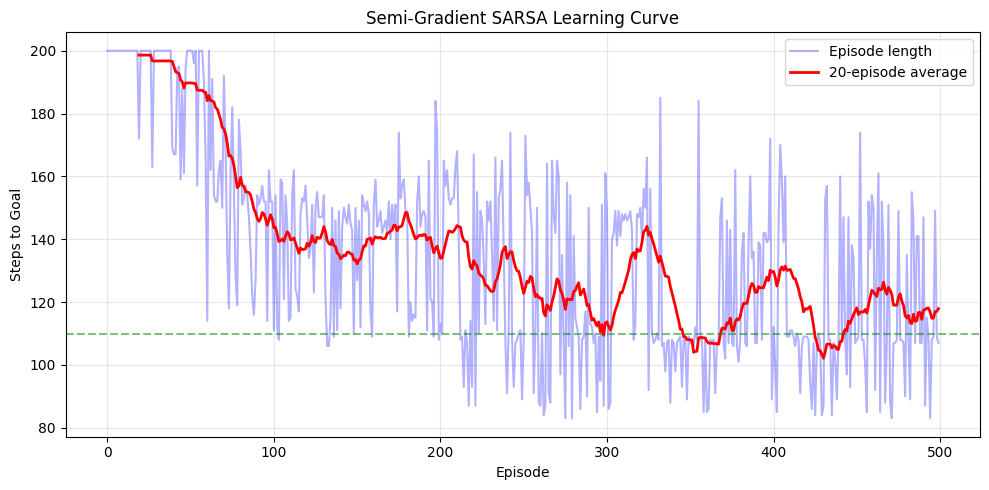

In [7]:
def plot_learning_curve(episode_lengths, window=20, title="Learning Curve"):
    """Plot episode lengths with moving average."""
    fig, ax = plt.subplots(figsize=(10, 5))

    # Raw data
    ax.plot(episode_lengths, alpha=0.3, color='blue', label='Episode length')

    # Moving average
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths,
                                  np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(episode_lengths)), moving_avg,
                color='red', linewidth=2, label=f'{window}-episode average')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps to Goal')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Reference line for MountainCar (optimal ~100-110 steps)
    ax.axhline(y=110, color='green', linestyle='--', alpha=0.5, label='~Optimal')

    plt.tight_layout()
    return fig

fig = plot_learning_curve(lengths, title="Semi-Gradient SARSA Learning Curve")
plt.show()

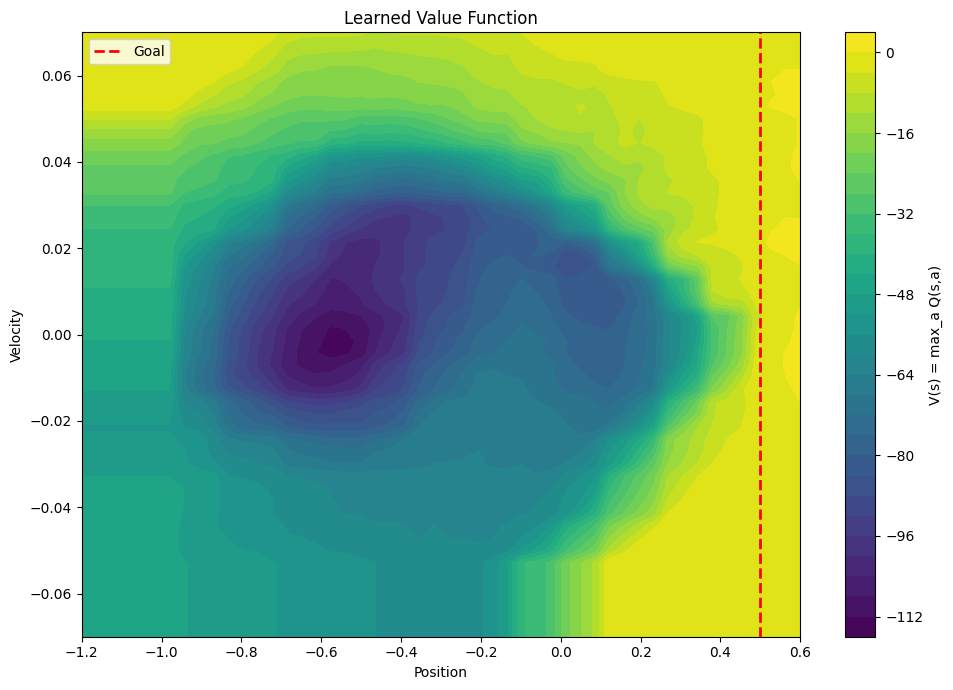

In [8]:
def plot_value_function(agent: SemiGradientSARSA, resolution: int = 50):
    """
    Plot learned value function V(s) = max_a Q(s,a) as heatmap.
    """
    positions = np.linspace(-1.2, 0.6, resolution)
    velocities = np.linspace(-0.07, 0.07, resolution)

    # Create meshgrid
    pos_grid, vel_grid = np.meshgrid(positions, velocities)

    # Compute V(s) = max_a Q(s,a) for each state
    V = np.zeros_like(pos_grid)

    for i in range(resolution):
        for j in range(resolution):
            state = np.array([pos_grid[i, j], vel_grid[i, j]])
            V[i, j] = np.max(agent.q_values(state))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 7))

    contour = ax.contourf(pos_grid, vel_grid, V, levels=30, cmap='viridis')
    plt.colorbar(contour, ax=ax, label='V(s) = max_a Q(s,a)')

    # Mark goal region
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Goal')

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title('Learned Value Function')
    ax.legend()

    plt.tight_layout()
    return fig

fig = plot_value_function(agent)
plt.show()

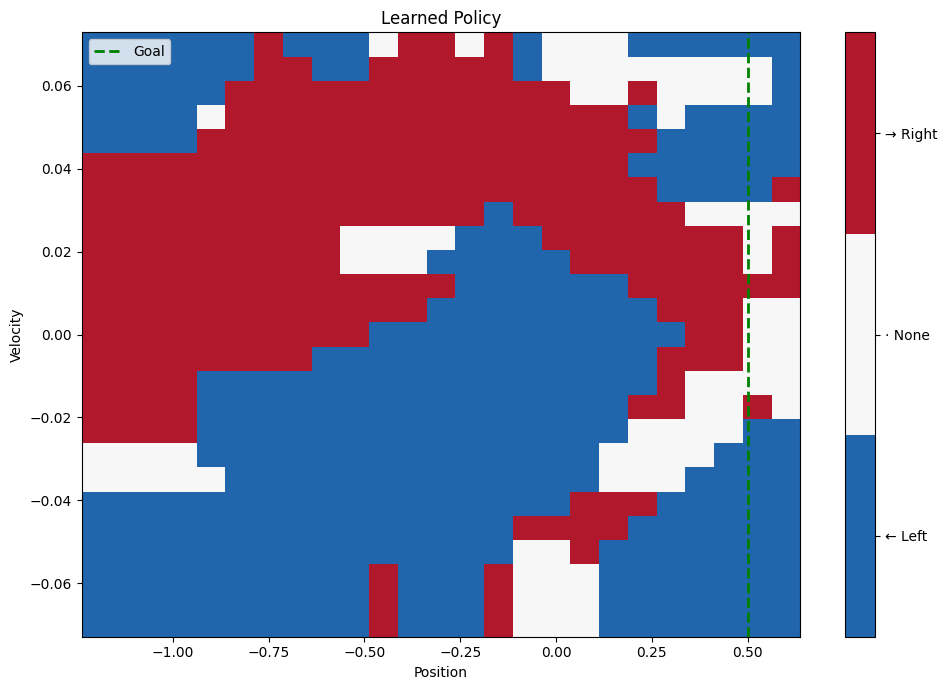

In [9]:
def plot_policy(agent: SemiGradientSARSA, resolution: int = 25):
    """
    Plot learned policy as action choices across state space.
    """
    positions = np.linspace(-1.2, 0.6, resolution)
    velocities = np.linspace(-0.07, 0.07, resolution)

    pos_grid, vel_grid = np.meshgrid(positions, velocities)

    # Compute best action for each state
    policy = np.zeros_like(pos_grid)

    for i in range(resolution):
        for j in range(resolution):
            state = np.array([pos_grid[i, j], vel_grid[i, j]])
            policy[i, j] = agent.greedy_action(state)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Custom colormap: left=blue, neutral=gray, right=red
    from matplotlib.colors import ListedColormap
    colors = ['#2166ac', '#f7f7f7', '#b2182b']  # blue, white, red
    cmap = ListedColormap(colors)

    im = ax.pcolormesh(pos_grid, vel_grid, policy, cmap=cmap,
                        vmin=-0.5, vmax=2.5, shading='auto')

    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['← Left', '· None', '→ Right'])

    ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Goal')

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title('Learned Policy')
    ax.legend()

    plt.tight_layout()
    return fig

fig = plot_policy(agent)
plt.show()

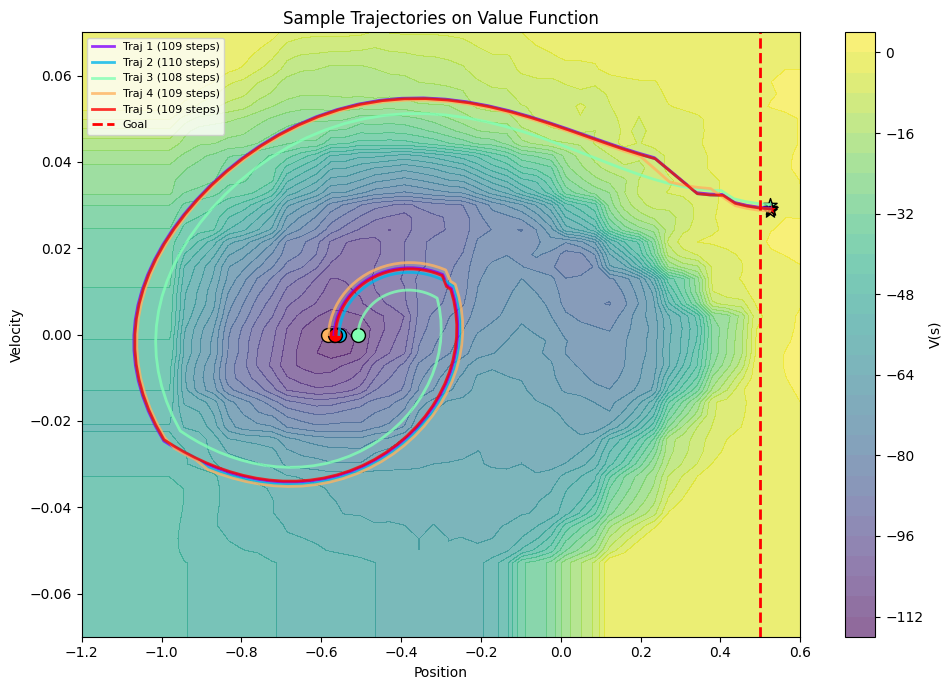

In [10]:
def plot_trajectories(env, agent: SemiGradientSARSA, num_trajectories: int = 5,
                      max_steps: int = 200):
    """
    Plot sample trajectories on value function background.
    """
    # First, create value function background
    resolution = 50
    positions = np.linspace(-1.2, 0.6, resolution)
    velocities = np.linspace(-0.07, 0.07, resolution)
    pos_grid, vel_grid = np.meshgrid(positions, velocities)

    V = np.zeros_like(pos_grid)
    for i in range(resolution):
        for j in range(resolution):
            state = np.array([pos_grid[i, j], vel_grid[i, j]])
            V[i, j] = np.max(agent.q_values(state))

    fig, ax = plt.subplots(figsize=(10, 7))

    # Background value function
    contour = ax.contourf(pos_grid, vel_grid, V, levels=30, cmap='viridis', alpha=0.6)
    plt.colorbar(contour, ax=ax, label='V(s)')

    # Generate trajectories from different starting positions
    colors = plt.cm.rainbow(np.linspace(0, 1, num_trajectories))

    for traj_idx in range(num_trajectories):
        state, _ = env.reset()

        trajectory = [state.copy()]

        for step in range(max_steps):
            action = agent.greedy_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            trajectory.append(next_state.copy())

            if terminated or truncated:
                break
            state = next_state

        trajectory = np.array(trajectory)

        # Plot trajectory
        ax.plot(trajectory[:, 0], trajectory[:, 1],
                color=colors[traj_idx], linewidth=2, alpha=0.8,
                label=f'Traj {traj_idx+1} ({len(trajectory)} steps)')
        ax.scatter(trajectory[0, 0], trajectory[0, 1],
                   color=colors[traj_idx], s=100, marker='o', edgecolor='black')
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1],
                   color=colors[traj_idx], s=100, marker='*', edgecolor='black')

    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Goal')

    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title('Sample Trajectories on Value Function')
    ax.legend(loc='upper left', fontsize=8)

    plt.tight_layout()
    return fig

fig = plot_trajectories(env, agent)
plt.show()


COMPARING FEATURE CONFIGURATIONS
Running: 4 tilings, 8×8...
Running: 8 tilings, 8×8...
Running: 16 tilings, 8×8...
Running: 8 tilings, 4×4...
Running: 8 tilings, 16×16...


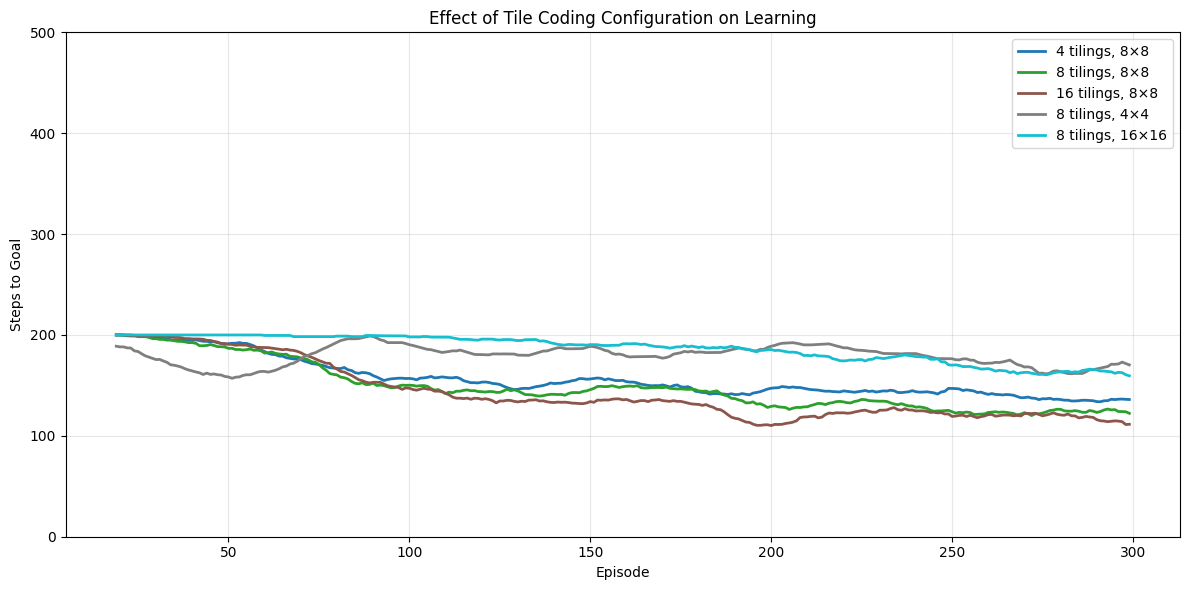


Final Performance (last 50 episodes):
--------------------------------------------------
4 tilings, 8×8      :  136.5 ±   5.8 steps
8 tilings, 8×8      :  123.4 ±   7.3 steps
16 tilings, 8×8     :  117.4 ±   0.5 steps
8 tilings, 4×4      :  168.2 ±   8.7 steps
8 tilings, 16×16    :  162.7 ±   1.9 steps


In [11]:
def run_experiment(num_tilings, tiles_per_dim, alpha, num_episodes=300,
                   num_runs=3, epsilon=0.0):
    """Run multiple training runs with given configuration."""
    all_lengths = []

    for run in range(num_runs):
        env = gym.make('MountainCar-v0')

        tile_coder = TileCoder(
            num_tilings=num_tilings,
            tiles_per_dim=[tiles_per_dim, tiles_per_dim],
            state_bounds=[(-1.2, 0.6), (-0.07, 0.07)]
        )

        agent = SemiGradientSARSA(
            tile_coder=tile_coder,
            num_actions=3,
            alpha=alpha,
            gamma=1.0,
            epsilon=epsilon
        )

        lengths, _ = train_sarsa(env, agent, num_episodes, verbose=False)
        all_lengths.append(lengths)

    return np.array(all_lengths)


# Compare configurations
print("\n" + "=" * 60)
print("COMPARING FEATURE CONFIGURATIONS")
print("=" * 60)

configs = [
    {"num_tilings": 4, "tiles_per_dim": 8, "alpha": 0.5, "label": "4 tilings, 8×8"},
    {"num_tilings": 8, "tiles_per_dim": 8, "alpha": 0.5, "label": "8 tilings, 8×8"},
    {"num_tilings": 16, "tiles_per_dim": 8, "alpha": 0.5, "label": "16 tilings, 8×8"},
    {"num_tilings": 8, "tiles_per_dim": 4, "alpha": 0.5, "label": "8 tilings, 4×4"},
    {"num_tilings": 8, "tiles_per_dim": 16, "alpha": 0.5, "label": "8 tilings, 16×16"},
]

results = {}
for cfg in configs:
    print(f"Running: {cfg['label']}...")
    results[cfg['label']] = run_experiment(
        cfg['num_tilings'], cfg['tiles_per_dim'], cfg['alpha'],
        num_episodes=300, num_runs=3
    )

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(configs)))

for (label, data), color in zip(results.items(), colors):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # Smooth with moving average
    window = 20
    if len(mean) >= window:
        mean_smooth = np.convolve(mean, np.ones(window)/window, mode='valid')
        x = range(window-1, len(mean))
        ax.plot(x, mean_smooth, label=label, color=color, linewidth=2)

ax.set_xlabel('Episode')
ax.set_ylabel('Steps to Goal')
ax.set_title('Effect of Tile Coding Configuration on Learning')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 500])

plt.tight_layout()
plt.show()

# Summary statistics
print("\nFinal Performance (last 50 episodes):")
print("-" * 50)
for label, data in results.items():
    final_avg = np.mean(data[:, -50:])
    final_std = np.std(np.mean(data[:, -50:], axis=1))
    print(f"{label:20s}: {final_avg:6.1f} ± {final_std:5.1f} steps")

In [12]:
def analyze_tile_coding():
    """Detailed analysis of tile coding properties."""

    print("\n" + "=" * 60)
    print("TILE CODING ANALYSIS")
    print("=" * 60)

    # Different configurations
    configs = [
        (4, 4),   # Coarse
        (8, 8),   # Standard
        (8, 16),  # More tiles
        (16, 8),  # More tilings
    ]

    print("\nConfiguration Analysis:")
    print("-" * 70)
    print(f"{'Tilings':>8} {'Tiles/Dim':>10} {'Features':>10} "
          f"{'Resolution':>12} {'Memory (KB)':>12}")
    print("-" * 70)

    for num_tilings, tiles_per_dim in configs:
        tc = TileCoder(num_tilings, [tiles_per_dim, tiles_per_dim],
                       [(-1.2, 0.6), (-0.07, 0.07)])

        # Effective resolution (how finely we can distinguish states)
        eff_res = num_tilings * tiles_per_dim

        # Memory for 3 actions (float64 = 8 bytes)
        memory_kb = (3 * tc.num_features * 8) / 1024

        print(f"{num_tilings:>8} {tiles_per_dim:>10} {tc.num_features:>10} "
              f"{eff_res:>12} {memory_kb:>12.1f}")

    # Generalization analysis
    print("\n\nGeneralization Analysis (8 tilings, 8×8):")
    print("-" * 50)

    tc = TileCoder(8, [8, 8], [(-1.2, 0.6), (-0.07, 0.07)])

    base_state = np.array([-0.5, 0.0])
    base_tiles = set(tc.get_active_tiles(base_state))

    # Test different distances
    distances = [0.01, 0.05, 0.1, 0.2, 0.5]

    print(f"Base state: {base_state}")
    print(f"{'Distance':>10} {'Shared Tiles':>15} {'Generalization':>15}")

    for dist in distances:
        nearby = np.array([-0.5 + dist, 0.0])
        nearby_tiles = set(tc.get_active_tiles(nearby))
        shared = len(base_tiles.intersection(nearby_tiles))
        gen_pct = shared / tc.num_tilings * 100
        print(f"{dist:>10.2f} {shared:>15} {gen_pct:>14.1f}%")

analyze_tile_coding()


TILE CODING ANALYSIS

Configuration Analysis:
----------------------------------------------------------------------
 Tilings  Tiles/Dim   Features   Resolution  Memory (KB)
----------------------------------------------------------------------
       4          4         64           16          1.5
       8          8        512           64         12.0
       8         16       2048          128         48.0
      16          8       1024          128         24.0


Generalization Analysis (8 tilings, 8×8):
--------------------------------------------------
Base state: [-0.5  0. ]
  Distance    Shared Tiles  Generalization
      0.01               7           87.5%
      0.05               6           75.0%
      0.10               4           50.0%
      0.20               0            0.0%
      0.50               0            0.0%
